## Predicting Customer Churn in Telecom: A Classification Model Approach

### Business Objectives
1. Develop a churn prediction model to identify high-risk customers early.
2. Implement retention strategies such as loyalty rewards, personalized discounts, and exclusive offers.
3. Monitor churn drivers (e.g., high monthly charges, short tenure) and address underlying issues.


### Hypothesis (H₁):
**"Payment methods and age of the customer, have a significant impact on the likelihood of churn in the telecommunication company."**

### Null Hypothesis (H₀):
**"Payment methods and age of the customer, do not have a significant impact on the likelihood of churn in the telecommunication company."**



##### Questions that would guide the analysis and exploration of this customer churn classification model project:

1. Which customer demographics and service-related features (e.g., contract type, payment method, monthly charges) have the highest correlation with customer churn?
  
2. What is the impact of customer tenure on the likelihood of churn, and do long-term customers have a lower probability of leaving the telecom service?

3. How does the type of contract (monthly vs. yearly) affect churn behavior, and is there a significant difference in churn rates between different contract types?

4. Which services (e.g., InternetService, StreamingTV) are most correlated with high customer retention?

5. What types of contracts (e.g., Month-to-month, One year) are more likely to retain customers?

6. Does the choice of PaymentMethod impact churn rates?

7. Does the length of tenure relate to the likelihood of churn, and what can be done to engage long-tenured customers?
  



In [120]:
#installing necessary packages.
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

In [114]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, RobustScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 


from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn. naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import lightgbm as lgb 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import joblib

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


In [5]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [6]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)


In [7]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "SELECT * FROM LP2_Telco_churn_first_3000"

data_1 = pd.read_sql(query, connection)

In [8]:
data_1

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2209-XADXF,Female,False,False,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,False,Bank transfer (automatic),25.250000,25.250000,False
2996,6620-JDYNW,Female,False,False,False,18,True,True,DSL,True,...,True,False,False,False,Month-to-month,True,Mailed check,60.599998,1156.349976,False
2997,1891-FZYSA,Male,True,True,False,69,True,True,Fiber optic,False,...,False,False,True,False,Month-to-month,True,Electronic check,89.949997,6143.149902,True
2998,4770-UEZOX,Male,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,74.750000,144.800003,False


In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [10]:
data_1["gender"].unique()

array(['Female', 'Male'], dtype=object)

In [11]:
data_1['SeniorCitizen'].unique()

array([False,  True])

In [12]:
data_1['Partner'].unique()

array([ True, False])

In [13]:
data_1['Dependents'].unique()

array([False,  True])

In [14]:
data_1['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [15]:
data_1['PhoneService'].unique()

array([False,  True])

In [16]:
data_1['MultipleLines'].unique()

array([None, False, True], dtype=object)

In [17]:
data_1['MultipleLines'].fillna(False,inplace=True)

In [18]:
data_1['MultipleLines'].value_counts()

MultipleLines
False    1706
True     1294
Name: count, dtype: int64

In [19]:
data_1['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [20]:
data_1['OnlineSecurity'].unique()

array([False, True, None], dtype=object)

In [21]:
data_1['OnlineSecurity'].fillna(True,inplace=True)

In [22]:
data_1['OnlineBackup'].unique()

array([True, False, None], dtype=object)

In [23]:
data_1['OnlineBackup'].fillna(True,inplace=True)

In [24]:
data_1['TechSupport'].unique()

array([False, True, None], dtype=object)

In [25]:
data_1['TechSupport'].fillna(False,inplace=True)

In [26]:
data_1['DeviceProtection'].unique()

array([False, True, None], dtype=object)

In [27]:
data_1['DeviceProtection'].fillna(True,inplace=True)

In [28]:
data_1['StreamingTV'].unique()

array([False, True, None], dtype=object)

In [29]:
data_1['StreamingTV'].fillna(False,inplace=True)

In [30]:
data_1['StreamingMovies'].unique()

array([False, True, None], dtype=object)

In [31]:
data_1['StreamingMovies'].fillna(True,inplace=True)

In [32]:
data_1['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [33]:
data_1['PaperlessBilling'].unique()

array([ True, False])

In [34]:
data_1['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [35]:
data_1['MonthlyCharges'].unique()

array([29.85000038, 56.95000076, 53.84999847, ..., 33.90000153,
       34.        , 38.59999847])

In [36]:
data_1['TotalCharges'].unique()

array([  29.85000038, 1889.5       ,  108.15000153, ..., 6143.14990234,
        144.80000305,  414.95001221])

In [37]:
data_1['TotalCharges'].fillna(data_1['TotalCharges'].mean(),inplace=True)

In [38]:
data_1['Churn'].unique()

array([False, True, None], dtype=object)

In [39]:
data_1['Churn'].fillna(False,inplace=True)

In [40]:
data_2 = pd.read_csv('Lp2_Telco-churn-second-2000.csv')

data_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [41]:
charges = data_2["TotalCharges"].to_list()
charges

['312.7',
 '1046.5',
 '2960.1',
 '834.2',
 '6953.4',
 '4134.85',
 '899.8',
 '541.5',
 '116.85',
 '7942.15',
 '5321.25',
 '4156.8',
 '223.6',
 '768.45',
 '3765.05',
 '2157.5',
 '108.05',
 '1391.65',
 '1379.8',
 '1273.3',
 '810.45',
 '1810.85',
 '7782.85',
 '70.3',
 '1797.1',
 '377.85',
 '445.3',
 '851.75',
 '7624.2',
 '355.1',
 '575.45',
 '906.85',
 '1057.55',
 '19.4',
 '1388.75',
 '1641.3',
 '1375.15',
 '152.7',
 '185.2',
 '195.05',
 '1826.7',
 '417.5',
 '344.5',
 '1660',
 '2180.55',
 '2835.9',
 '45.15',
 '2730.85',
 '5437.1',
 '20.2',
 '6981.35',
 '5794.45',
 '747.2',
 '1267.95',
 '3674.95',
 '1275.6',
 '5893.9',
 '724.65',
 '1536.75',
 '3615.6',
 '607.3',
 '4154.55',
 '2184.35',
 '1852.85',
 '77.15',
 '847.8',
 '2390.45',
 '1923.5',
 '1493.2',
 '338.1',
 '3030.6',
 '75.35',
 '2184.85',
 '1031.4',
 '921.3',
 '3875.4',
 '3124.5',
 '144.15',
 '6689',
 '1451.1',
 '6368.2',
 '3729.6',
 '350.1',
 '2847.2',
 '452.35',
 '1494.5',
 '930.45',
 '41.85',
 '1272.05',
 '475.1',
 '673.1',
 '208.7',

In [42]:
data_2["TotalCharges"]=pd.to_numeric(data_2["TotalCharges"], errors='coerce')
data_2["TotalCharges"]

0        312.70
1       1046.50
2       2960.10
3        834.20
4       6953.40
         ...   
2038    1990.50
2039    7362.90
2040     346.45
2041     306.60
2042    6844.50
Name: TotalCharges, Length: 2043, dtype: float64

In [43]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [44]:
charges = data_2['TotalCharges'].to_list()
print(charges)

[312.7, 1046.5, 2960.1, 834.2, 6953.4, 4134.85, 899.8, 541.5, 116.85, 7942.15, 5321.25, 4156.8, 223.6, 768.45, 3765.05, 2157.5, 108.05, 1391.65, 1379.8, 1273.3, 810.45, 1810.85, 7782.85, 70.3, 1797.1, 377.85, 445.3, 851.75, 7624.2, 355.1, 575.45, 906.85, 1057.55, 19.4, 1388.75, 1641.3, 1375.15, 152.7, 185.2, 195.05, 1826.7, 417.5, 344.5, 1660.0, 2180.55, 2835.9, 45.15, 2730.85, 5437.1, 20.2, 6981.35, 5794.45, 747.2, 1267.95, 3674.95, 1275.6, 5893.9, 724.65, 1536.75, 3615.6, 607.3, 4154.55, 2184.35, 1852.85, 77.15, 847.8, 2390.45, 1923.5, 1493.2, 338.1, 3030.6, 75.35, 2184.85, 1031.4, 921.3, 3875.4, 3124.5, 144.15, 6689.0, 1451.1, 6368.2, 3729.6, 350.1, 2847.2, 452.35, 1494.5, 930.45, 41.85, 1272.05, 475.1, 673.1, 208.7, 150.75, 3199.0, 5844.65, 2462.6, 6263.8, 3403.4, 237.75, 221.35, 75.3, 1672.1, 7881.2, 2320.8, 370.5, 4062.2, 3043.7, 2723.4, 1081.25, 4097.05, 632.2, 4042.3, 164.85, 8166.8, 4113.7, 3047.15, 70.4, 4193.4, 3729.75, 399.45, 331.3, 1964.6, 1336.15, 1147.45, 486.05, 1078.9

In [45]:
charges = data_2['TotalCharges'].fillna(data_2['TotalCharges'].median(),inplace=True)

In [46]:
train_data = pd.concat([data_1, data_2],ignore_index=True)
train_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,False,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,False,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes


In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     5043 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    5043 non-null   object 
 10  OnlineBackup      5043 non-null   object 
 11  DeviceProtection  5043 non-null   object 
 12  TechSupport       5043 non-null   object 
 13  StreamingTV       5043 non-null   object 
 14  StreamingMovies   5043 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [48]:
train_data['SeniorCitizen'].unique()

array([False, True], dtype=object)

In [49]:
train_data.replace({False:'No', True:'Yes'},inplace=True)

In [50]:
train_data['SeniorCitizen'].replace({False:0,True:1},inplace=True)

In [51]:
train_data.to_csv('Train-set.csv',index=False)

In [52]:
train_data = train_data.drop(columns=['customerID'])

In [53]:
from ydata_profiling import ProfileReport

In [54]:
profile = ProfileReport(train_data,title='Telecom-churn-5000')

In [55]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Univariate Analysis

In [56]:
%matplotlib inline

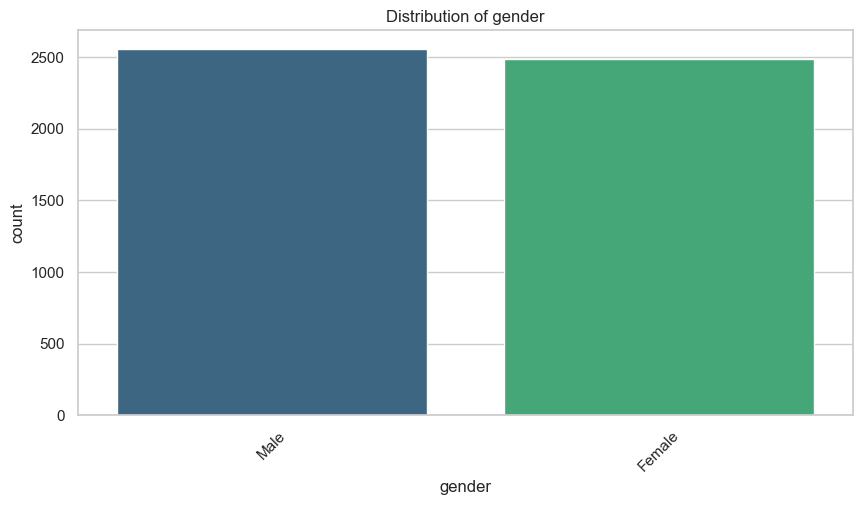

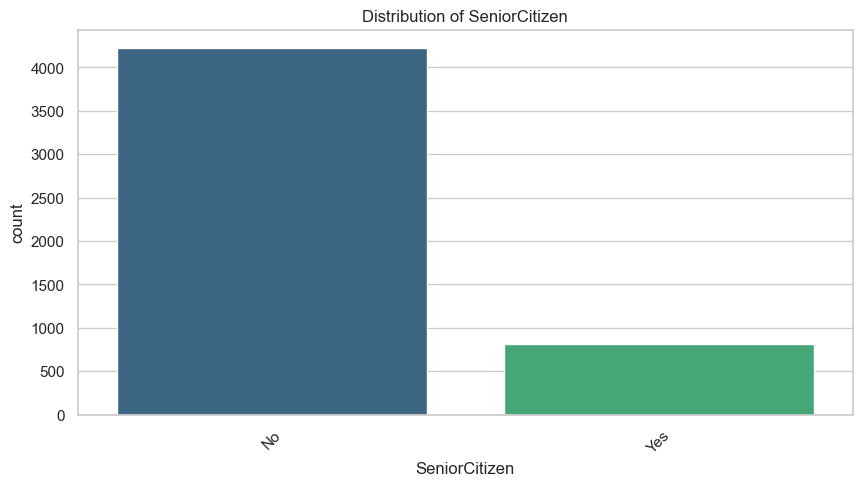

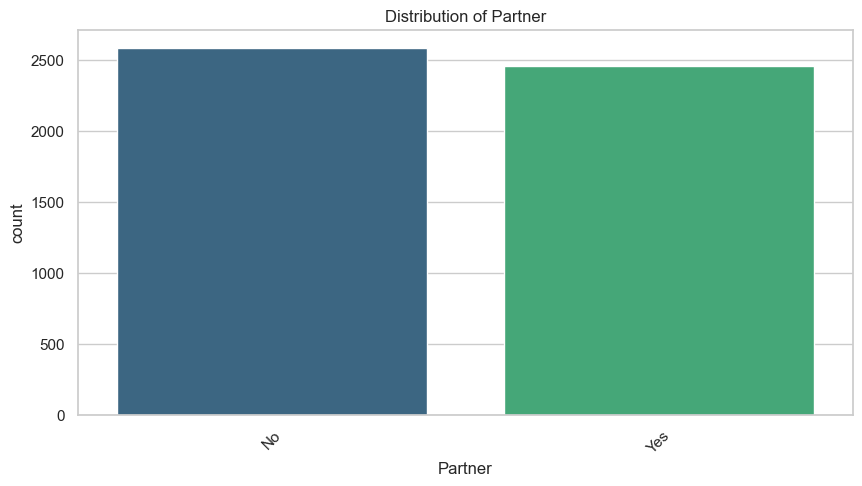

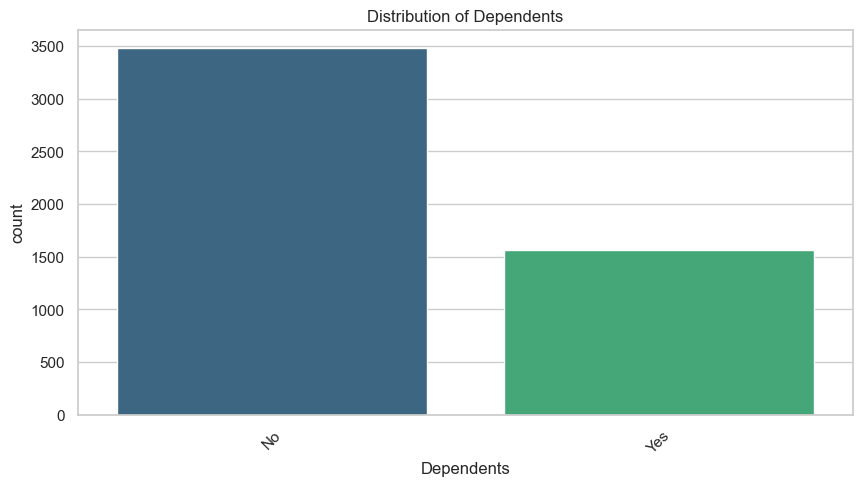

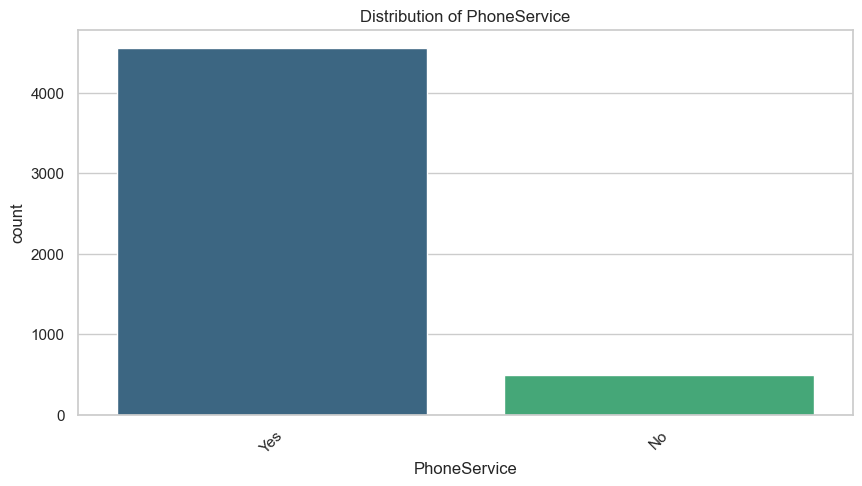

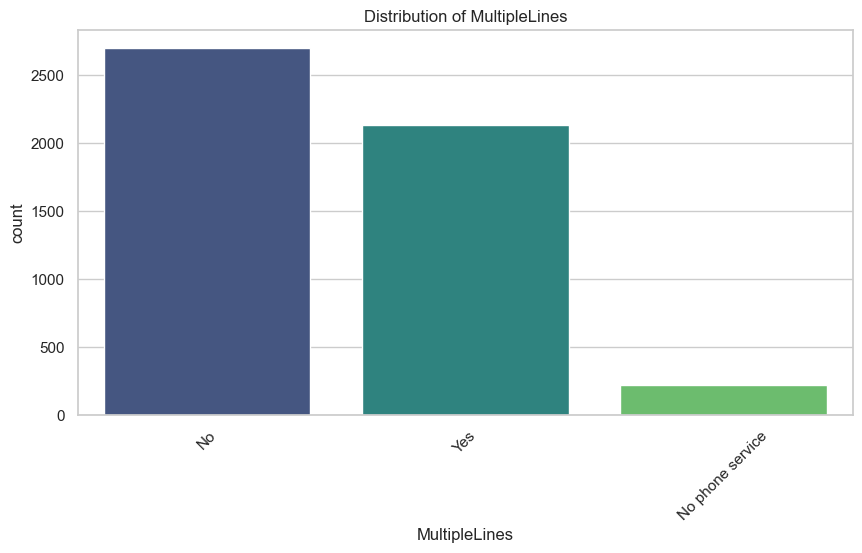

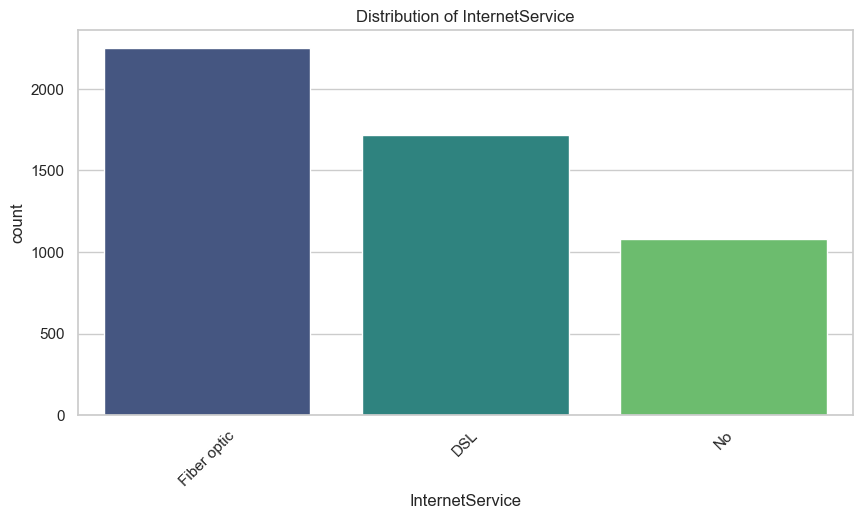

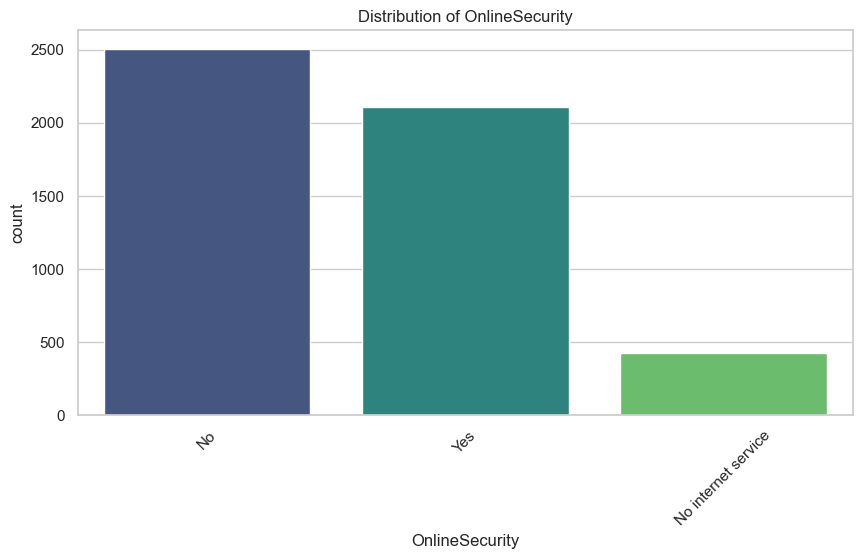

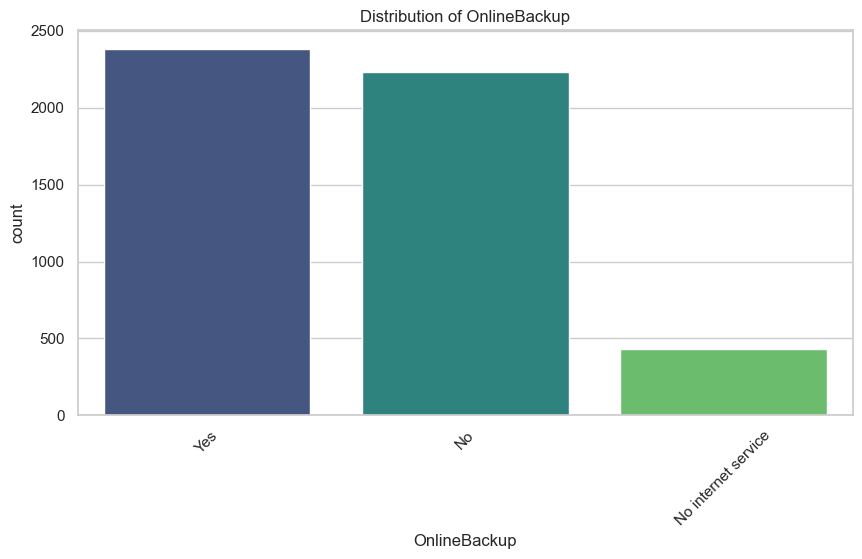

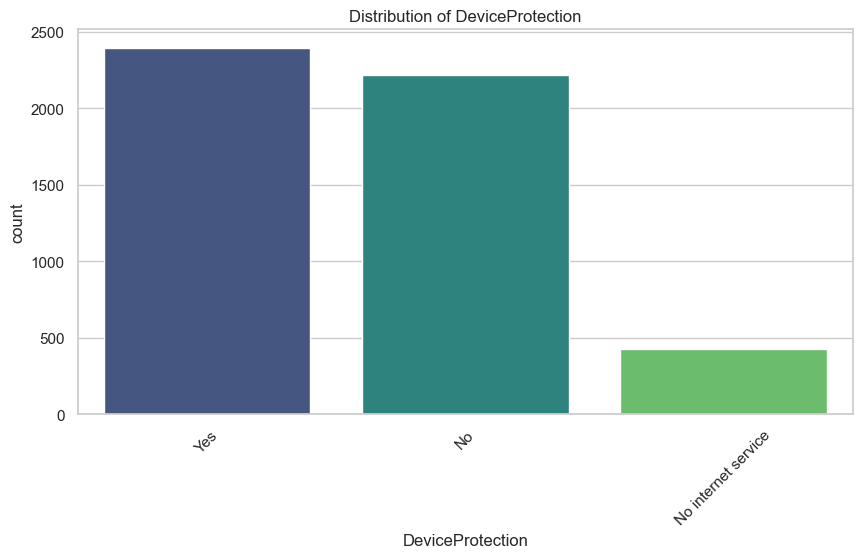

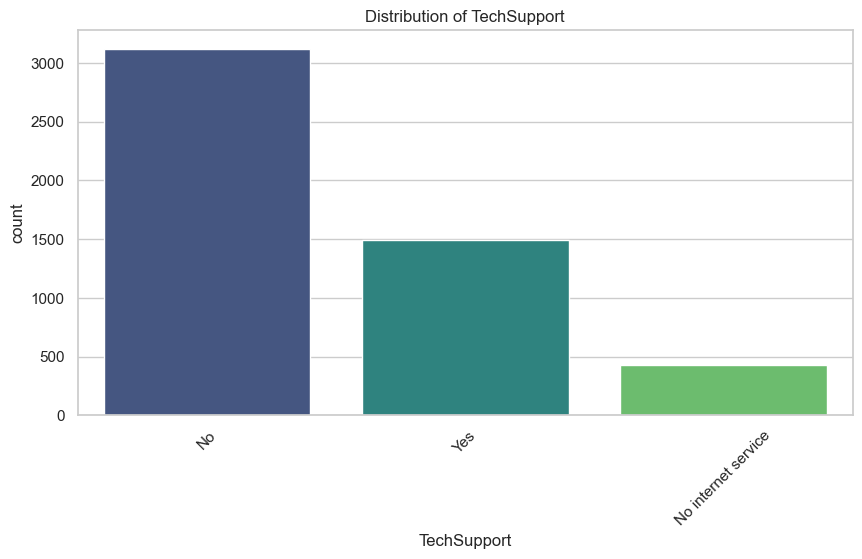

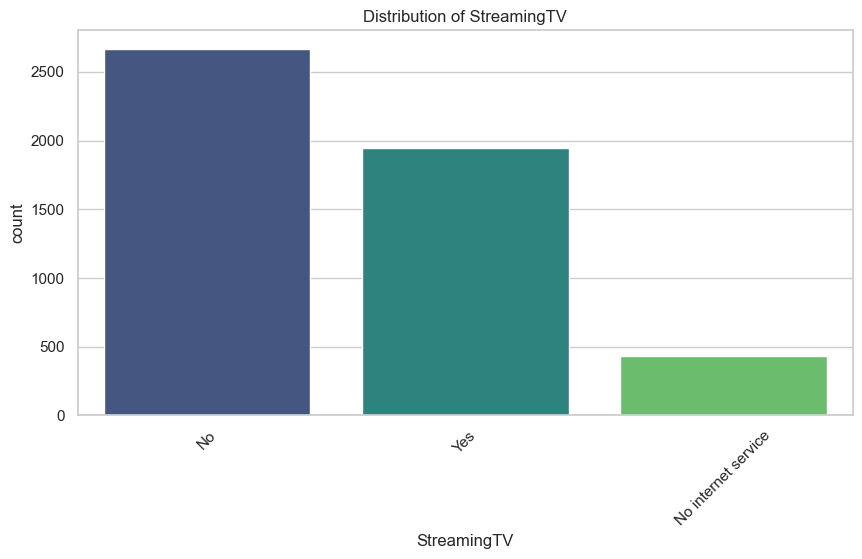

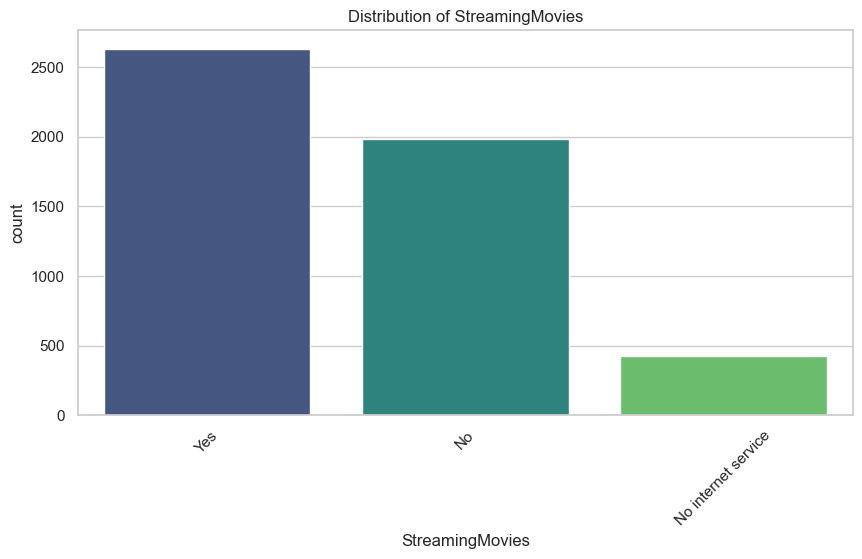

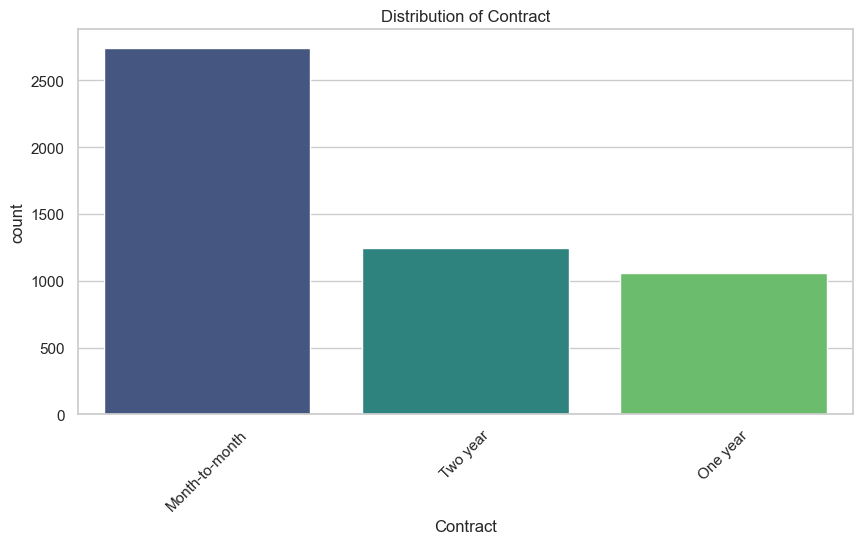

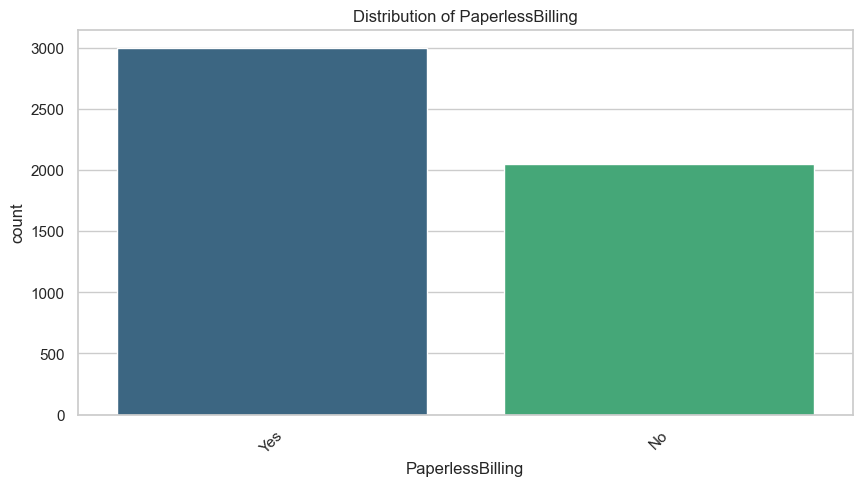

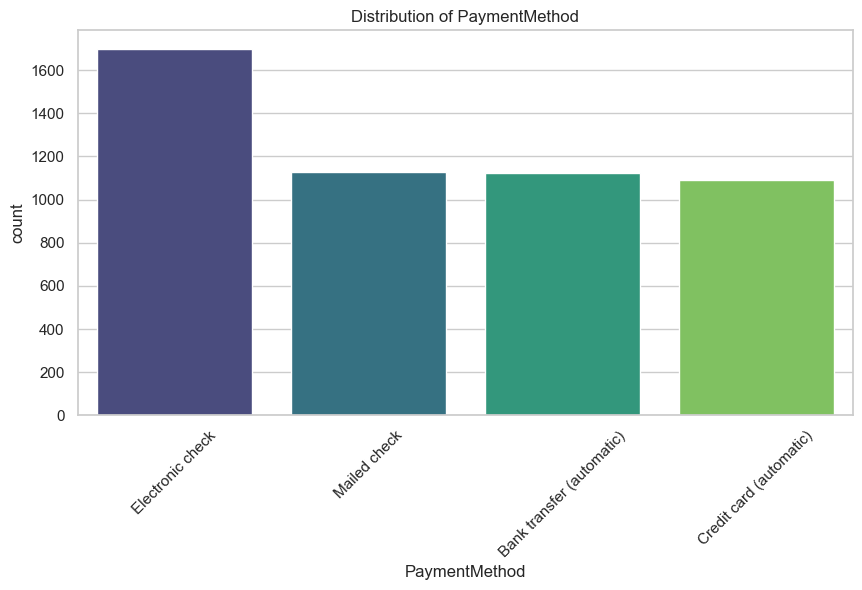

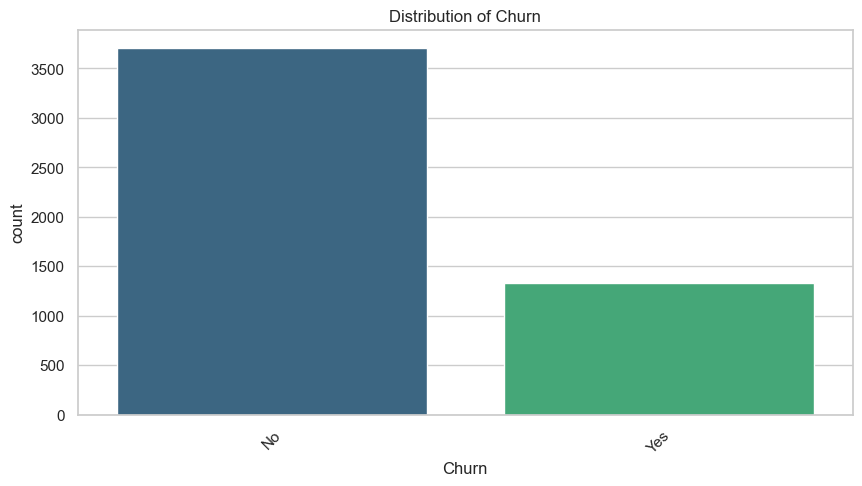

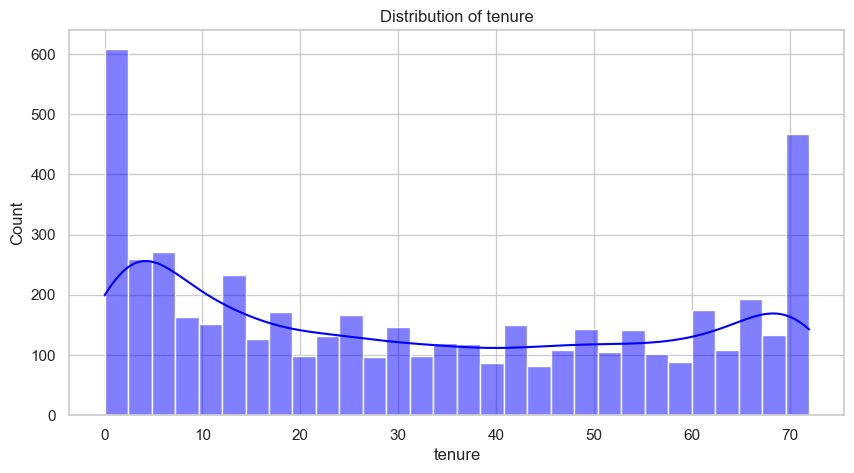

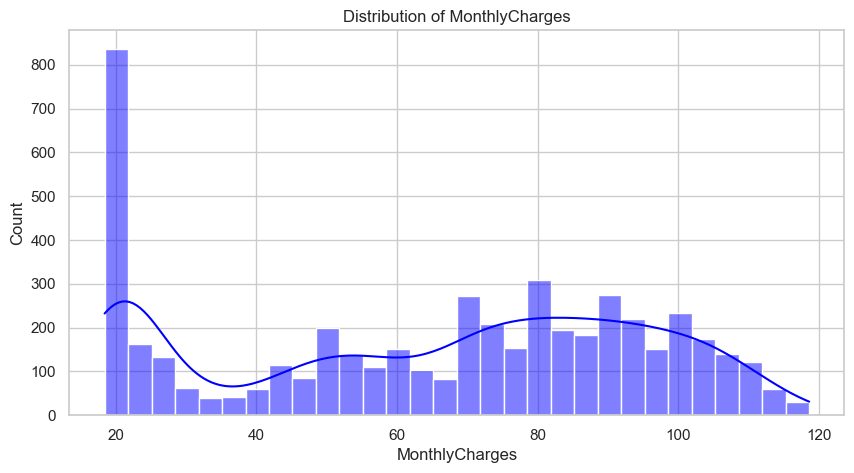

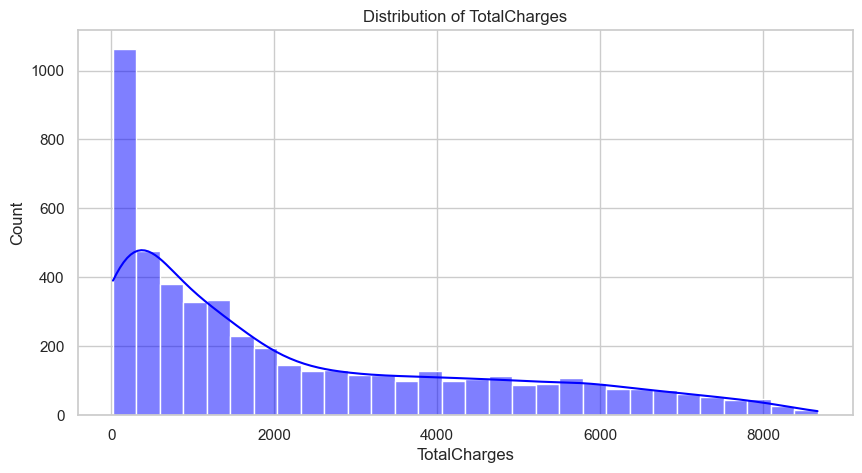

In [57]:
# Configure visualization style
sns.set(style="whitegrid", palette="pastel")

# Function to perform univariate analysis
def univariate_analysis(train_data):
    # Identify categorical and numerical columns
    categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
    numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

    # Univariate analysis for categorical variables
    for column in categorical_columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=train_data, x=column, palette='viridis', order=train_data[column].value_counts().index)
        plt.title(f'Distribution of {column}')
        plt.xticks(rotation=45)
        plt.show()

    # Univariate analysis for numerical variables
    for column in numerical_columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(train_data[column], bins=30, kde=True, color='blue')
        plt.title(f'Distribution of {column}')
        plt.show()

# Call the function
univariate_analysis(train_data)


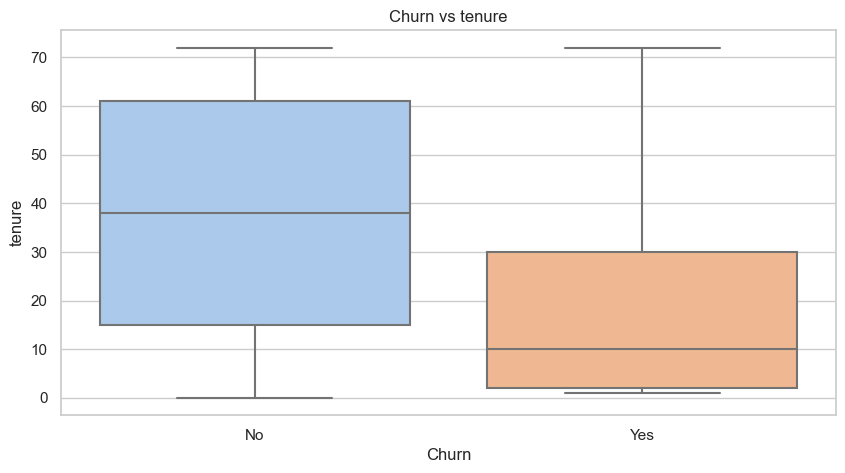

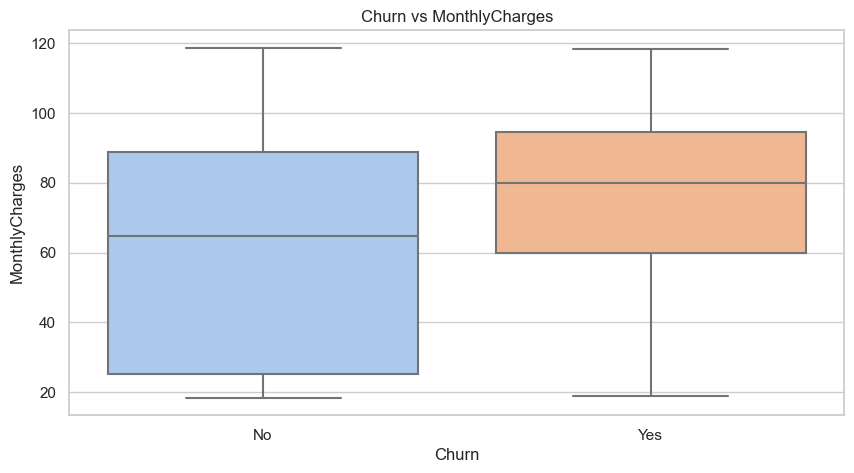

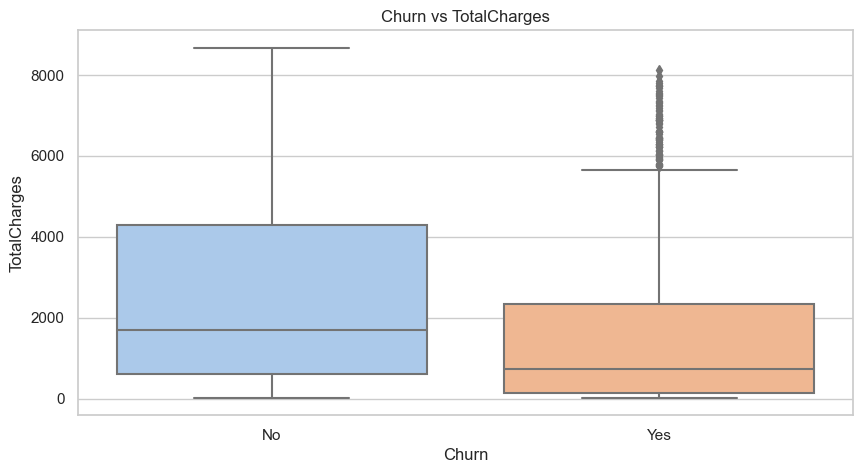

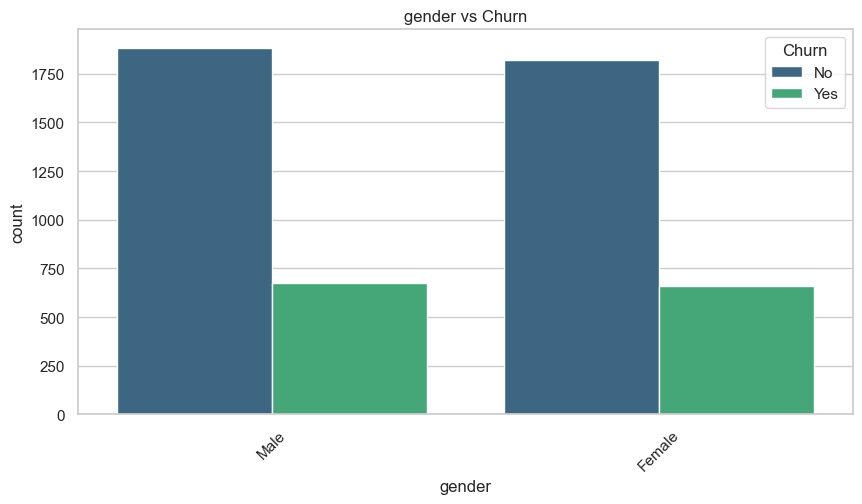

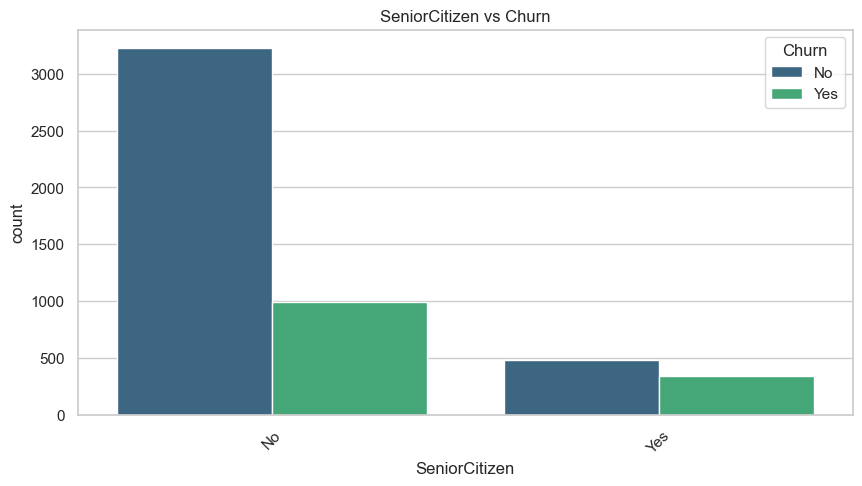

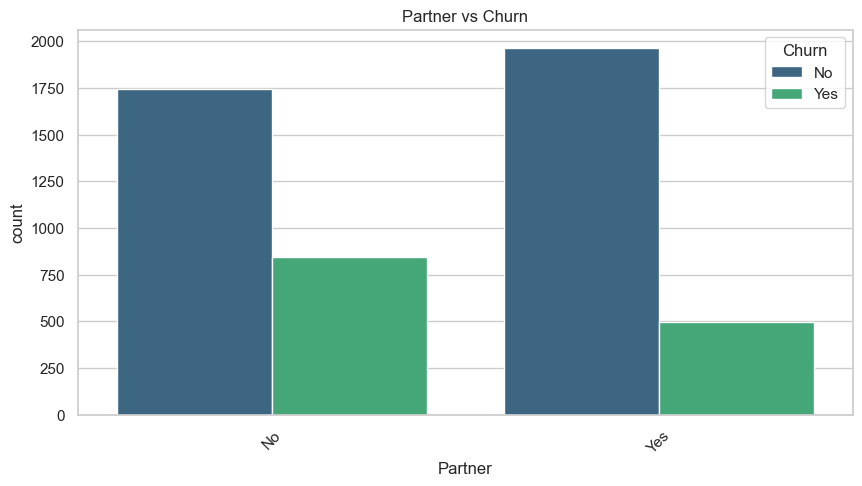

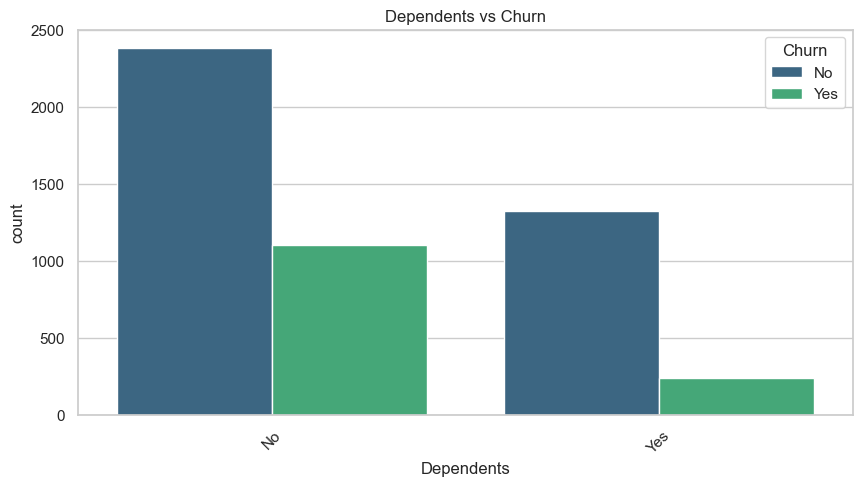

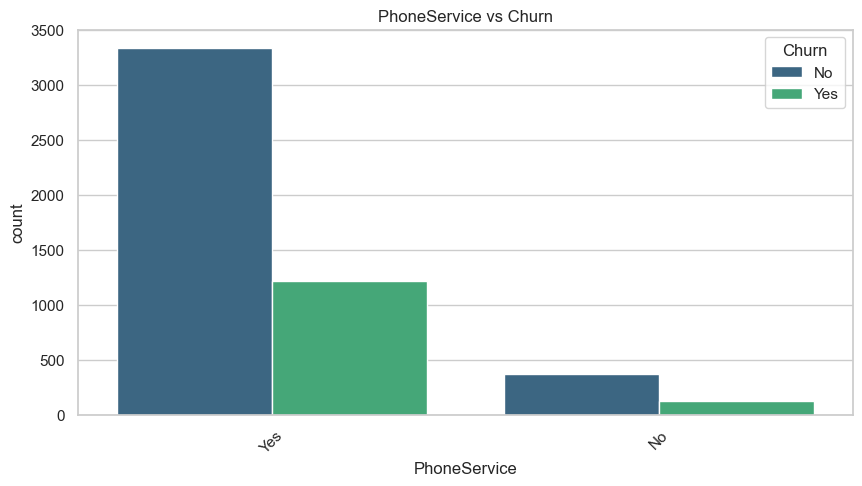

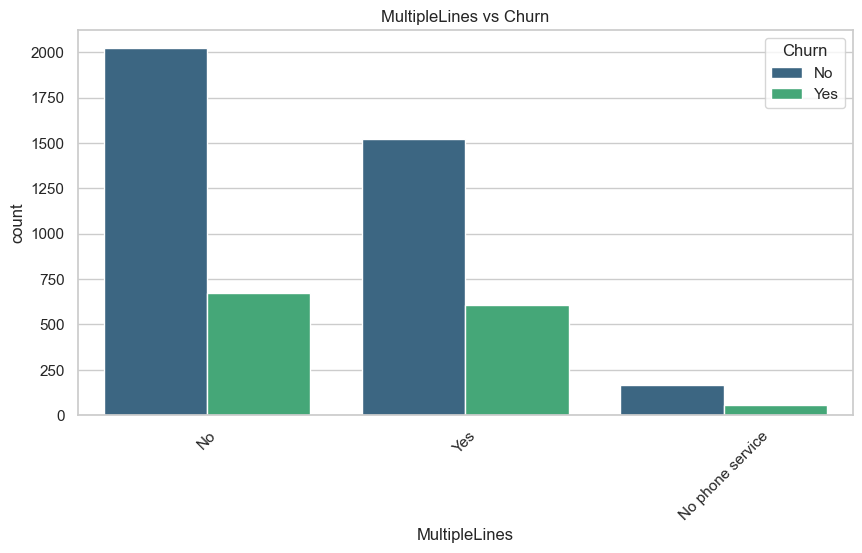

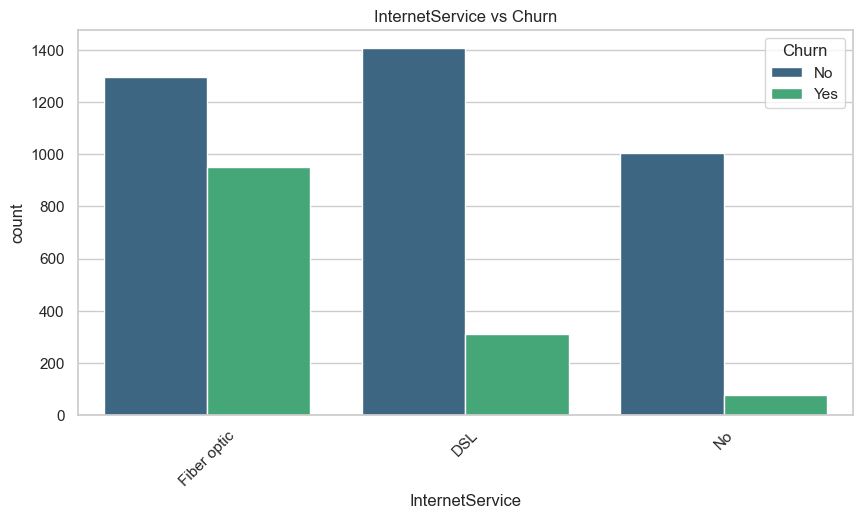

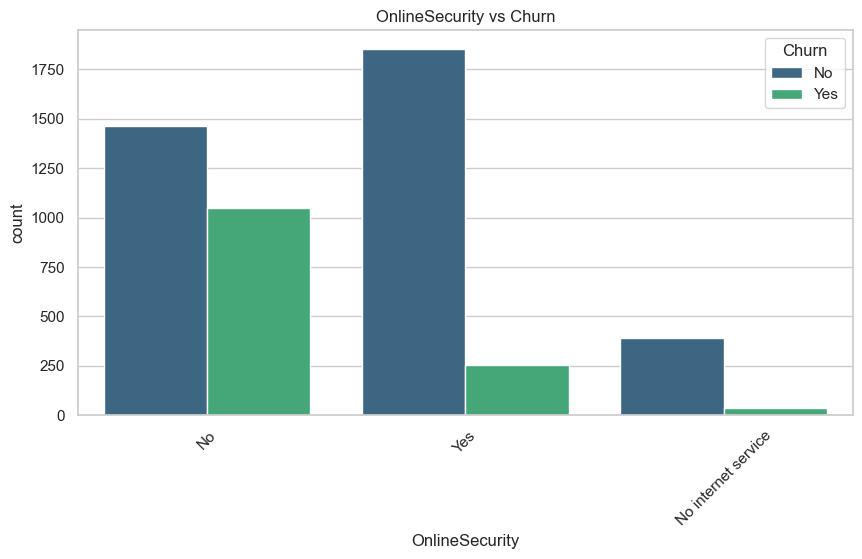

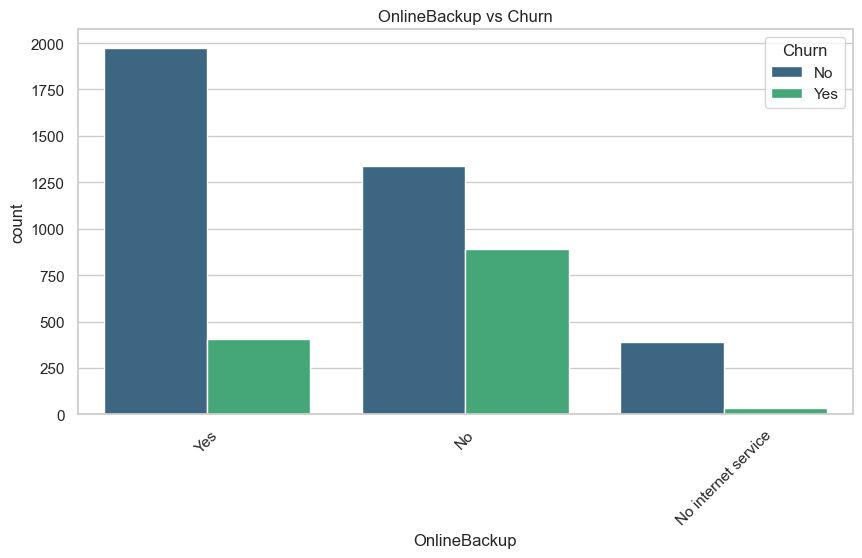

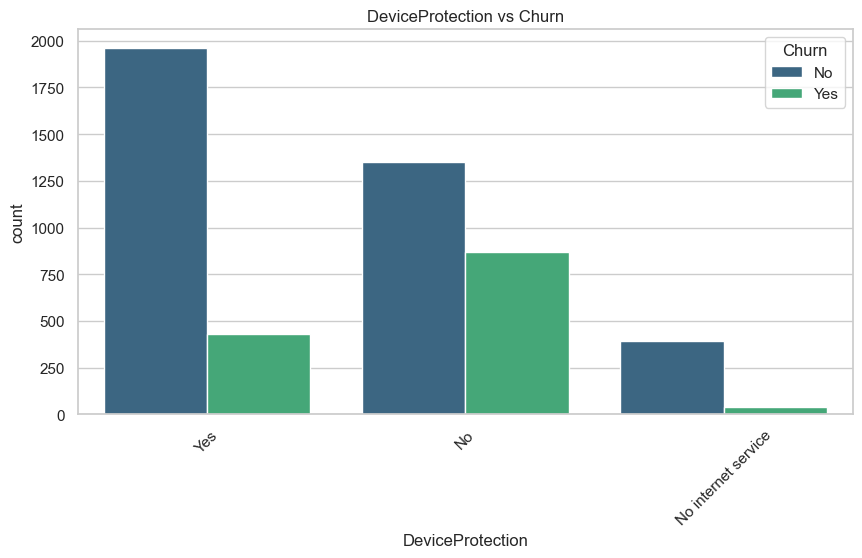

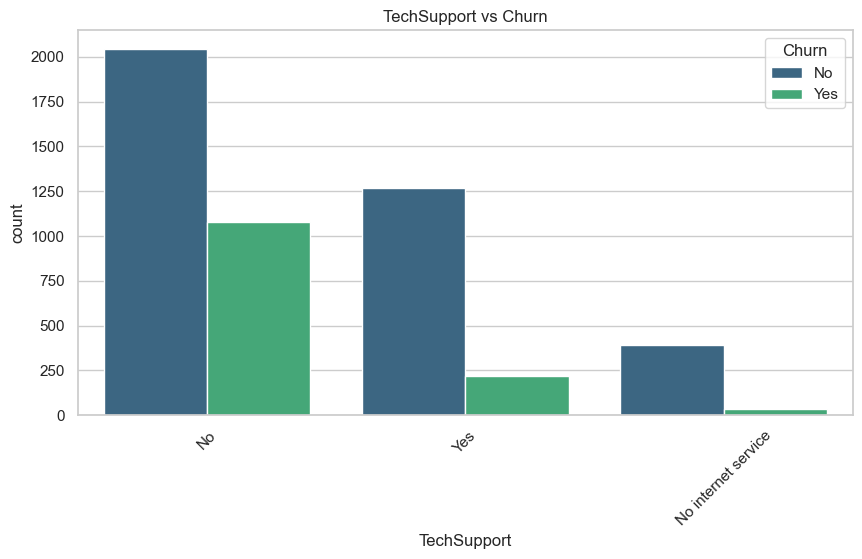

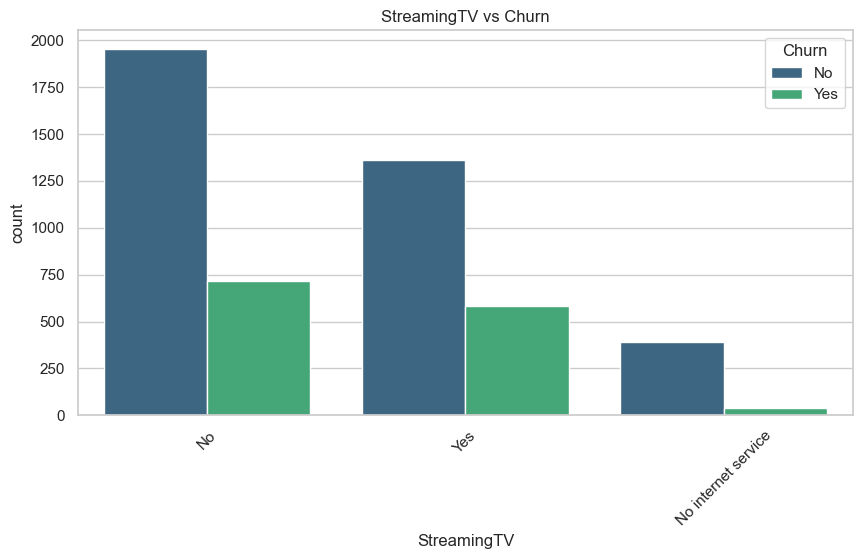

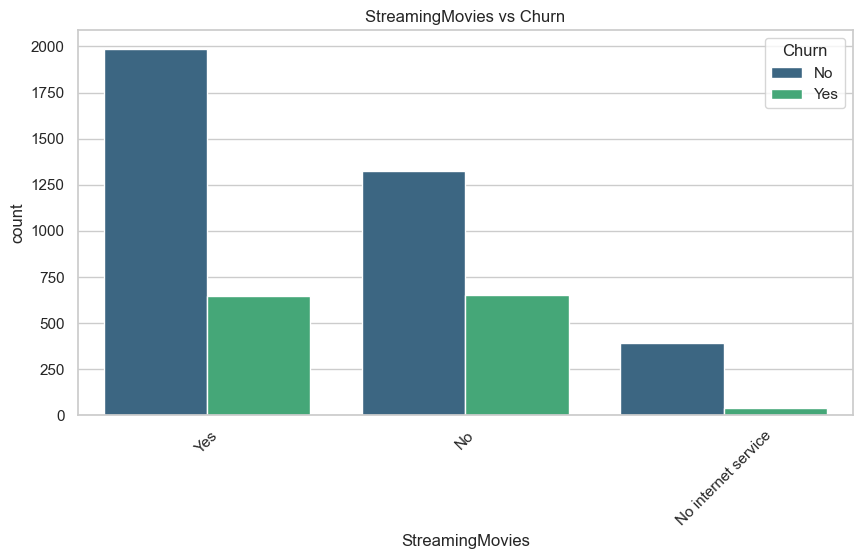

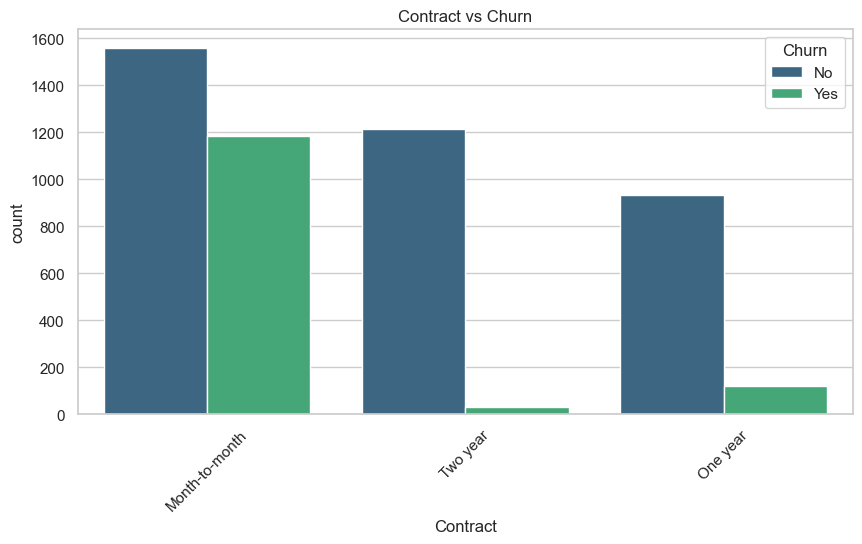

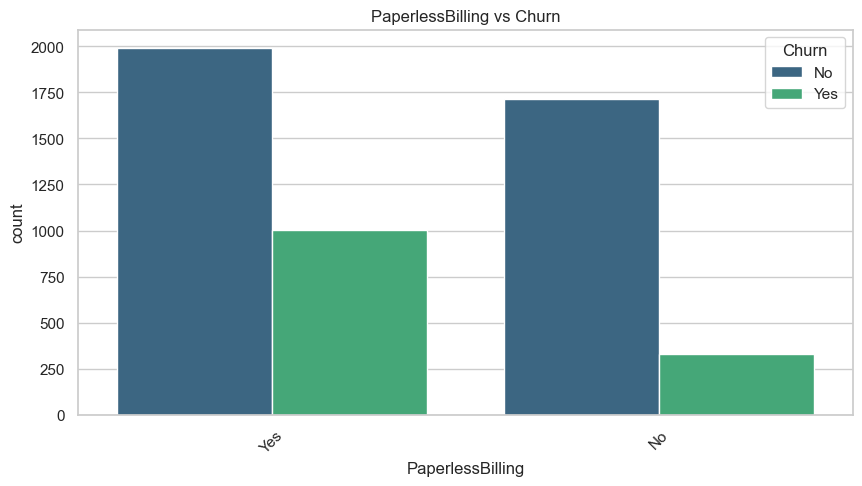

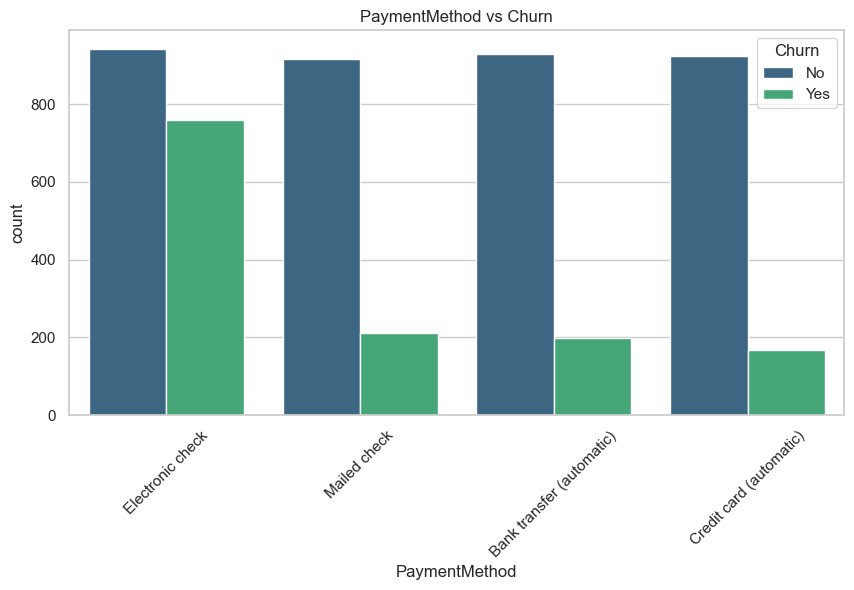

In [58]:
# Configure visualization style
sns.set(style="whitegrid", palette="pastel")

# Function for bivariate analysis
def bivariate_analysis(train_data):
    # Example pairings for analysis
    target_variable = 'Churn'  # Update to your dataset's target variable
    
    # Numerical vs Target Variable
    numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
    for column in numerical_columns:
        if column != target_variable:
            plt.figure(figsize=(10, 5))
            sns.boxplot(data=train_data, x=target_variable, y=column, palette='pastel')
            plt.title(f'{target_variable} vs {column}')
            plt.show()

    # Categorical vs Target Variable
    categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
    for column in categorical_columns:
        if column != target_variable:
            plt.figure(figsize=(10, 5))
            sns.countplot(data=train_data, x=column, hue=target_variable, palette='viridis', order=train_data[column].value_counts().index)
            plt.title(f'{column} vs {target_variable}')
            plt.xticks(rotation=45)
            plt.show()

# Call the function
bivariate_analysis(train_data)


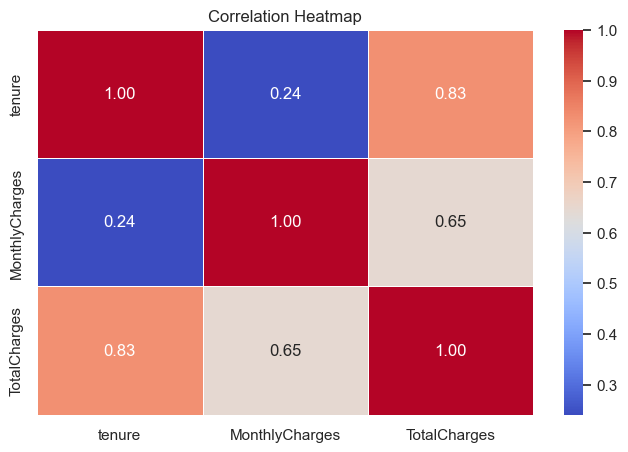

In [59]:
# Function to plot correlation heatmap
def plot_correlation_heatmap(train_data):
    # Select only numerical columns for correlation
    numerical_data = train_data.select_dtypes(include=['int64', 'float64'])
    
    # Compute the correlation matrix
    correlation_matrix = numerical_data.corr()
    
    # Plot the heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

# Call the function
plot_correlation_heatmap(train_data)


### Data Preparation

In [60]:
# Create a copy of my train_data 

train_mod = train_data.copy()

In [61]:
# Checking for data imbalance

train_mod['Churn'].value_counts()

Churn
No     3707
Yes    1336
Name: count, dtype: int64

In [62]:
# Data resampling 
churn_major = train_mod[train_mod['Churn']=='No']
churn_minor = train_mod[train_mod['Churn']=='Yes']

minor_resampled = resample(churn_minor, replace = True, n_samples = len(churn_major), random_state = 42)


train_model = pd.concat([churn_major,minor_resampled])

train_model['Churn'].value_counts()



Churn
No     3707
Yes    3707
Name: count, dtype: int64

In [63]:
# Splitting the dataset into x and y (target column)

x = train_model.drop(columns = ['Churn'])
y = train_model['Churn']

In [64]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [65]:
num_cols = x.select_dtypes(include = ['int64','float64']).columns
cat_cols = x.select_dtypes(include = ['object']).columns

In [66]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.2, random_state = 42, stratify = y)

In [67]:
print(x_train.shape)
print(x_val.shape)

(5931, 19)
(1483, 19)


In [68]:
num_pipe = Pipeline(steps =[
    ('scaler',RobustScaler()),
    ('qt',QuantileTransformer(output_distribution = 'normal'))
])

cat_pipe = Pipeline(steps =[
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
])

preprocessor = ColumnTransformer(transformers = [
    ('numerical',num_pipe, num_cols),
    ('categorical',cat_pipe, cat_cols)
])

preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('qt',
                                                  QuantileTransformer(output_distribution='normal'))]),
                                 Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])

In [69]:
models = [
    ('KNN', KNeighborsClassifier(n_neighbors=10)),
    ('LR', LogisticRegression(max_iter = 100, random_state=42,verbose=0)),
    ('DT', DecisionTreeClassifier(criterion = 'entropy',random_state=42)),
    ('RF', RandomForestClassifier(random_state=42, n_estimators=100,max_depth=None)),
    ('SVC', SVC(probability=True,random_state=42,C=1.0,gamma='scale')),
    ('GB', GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate = 0.1,max_depth=3)),
    ('XB', XGBClassifier(random_state=42, use_label_encoder = False, eval_metric = 'logloss', n_estimators=100))
]

# Defining Oversampling technique
sampler = SMOTE(random_state = 42)


pipelines =[]


In [70]:
for model, classifier in models:
    pipeline = ImbPipeline(steps=[
        ('preprocessor',preprocessor),
        ('smote_sampler',sampler),
        ('model',classifier)
    ])

    pipelines.append((model,pipeline))

In [71]:
eval_result = {}

for model, classifier in models:
    pipeline = ImbPipeline(steps=[
        ('preprocessor',preprocessor),
        ('smote_sampler',sampler),
        ('model',classifier)
    ])

    pipeline.fit(x_train, y_train)

    x_val_processed = pipeline.named_steps['preprocessor'].transform(x_val)

    y_pred = pipeline.named_steps['model'].predict(x_val_processed)

    accuracy = accuracy_score(y_val,y_pred)
    f1 = f1_score(y_val,y_pred)
    precision = precision_score(y_val,y_pred)
    recall = recall_score(y_val,y_pred)
    conf_matrix = confusion_matrix(y_val,y_pred)


    eval_result[model] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions':y_pred,
        'confusion_matrix': conf_matrix
    }

    scores_df = pd.DataFrame(eval_result).transpose()

scores_dff = scores_df.sort_values(by ='f1_score', ascending = False)

print('Model Scores:')
scores_dff

Model Scores:


,accuracy,f1_score,precision,recall,predictions,confusion_matrix
RF,0.895482,0.901961,0.84881,0.962213,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[[615, 127], [28, 713]]"
DT,0.873904,0.883052,0.822844,0.952767,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[[590, 152], [35, 706]]"
XB,0.870533,0.879093,0.824085,0.94197,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[[593, 149], [43, 698]]"
GB,0.784895,0.796426,0.755448,0.842105,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[[540, 202], [117, 624]]"
SVC,0.779501,0.793169,0.746429,0.846154,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[[529, 213], [114, 627]]"
LR,0.770735,0.781772,0.74541,0.821862,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[[534, 208], [132, 609]]"
KNN,0.757923,0.771192,0.730676,0.816464,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[[519, 223], [136, 605]]"


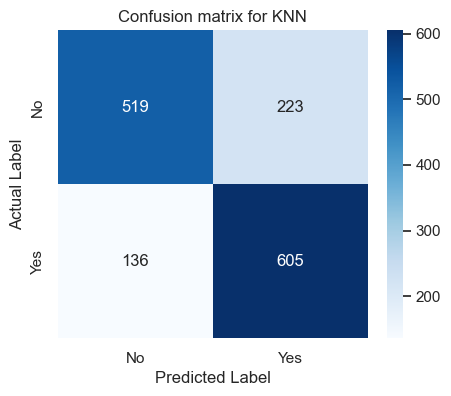

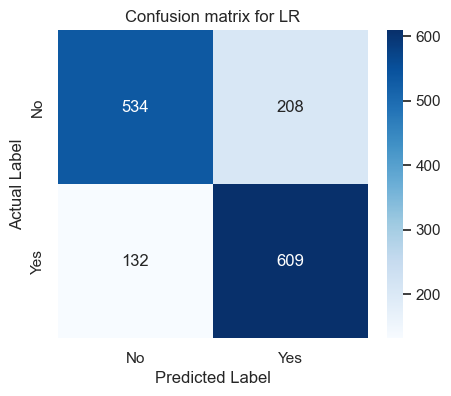

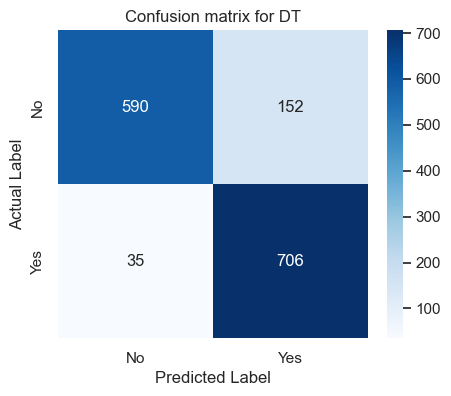

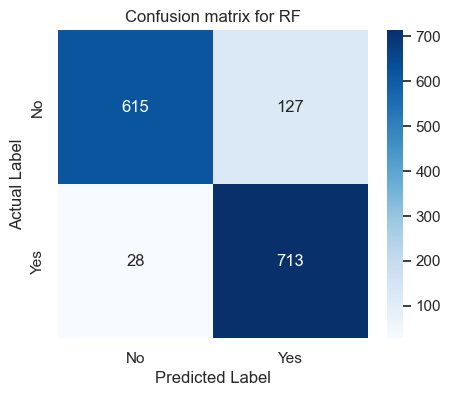

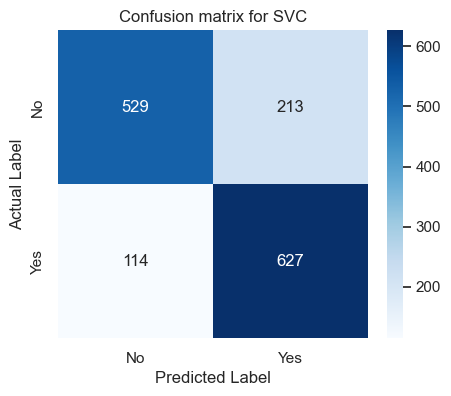

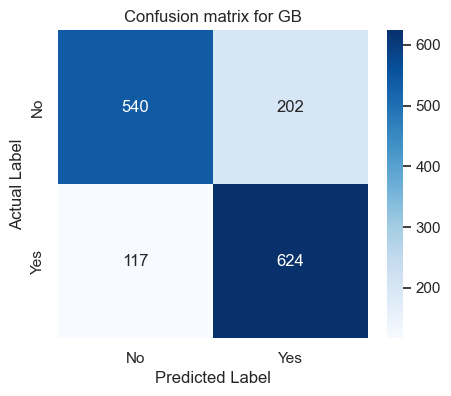

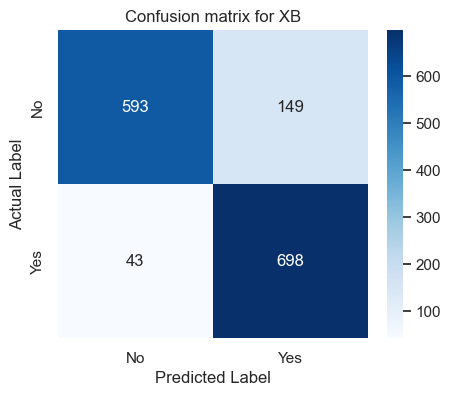

In [72]:
def confusion_matrix(conf_matrix,model):
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt= 'd',cmap = 'Blues', xticklabels =['No','Yes'],yticklabels=['No','Yes'])
    plt.title(f'Confusion matrix for {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

for model in eval_result.keys():
    conf_matrix = eval_result[model]['confusion_matrix']
    confusion_matrix(conf_matrix,model)

In [73]:
from sklearn.metrics import classification_report

for  model, classifier in models:
    print(f'Classification report for {model}: ')
    print(classification_report(y_val,y_pred, target_names= ['No','Yes']))
    print("="*30+"\n")

Classification report for KNN: 
              precision    recall  f1-score   support

          No       0.93      0.80      0.86       742
         Yes       0.82      0.94      0.88       741

    accuracy                           0.87      1483
   macro avg       0.88      0.87      0.87      1483
weighted avg       0.88      0.87      0.87      1483


Classification report for LR: 
              precision    recall  f1-score   support

          No       0.93      0.80      0.86       742
         Yes       0.82      0.94      0.88       741

    accuracy                           0.87      1483
   macro avg       0.88      0.87      0.87      1483
weighted avg       0.88      0.87      0.87      1483


Classification report for DT: 
              precision    recall  f1-score   support

          No       0.93      0.80      0.86       742
         Yes       0.82      0.94      0.88       741

    accuracy                           0.87      1483
   macro avg       0.88      0.8

### Hyperparameter Tunning

In [74]:
# Define hyperparameter grids
param_grids = {
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9],
        "model__weights": ['uniform','distance'],
        "model__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
        },
    "LR": {
        "model__C": [0.1, 1, 10], 
        "model__solver": ["lbfgs", "liblinear"],
        "model__penalty": ["l2", "l1"]
        },
    "RF": {
        "model__n_estimators": [50, 100, 200], 
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2,5,10],
        "model__min_samples_leaf": [1,2,4]
        },
    "SVC": {
        "model__C": [0.1, 1, 10], 
        "model__gamma": ["scale", "auto"],
        "model__kernel": ["rbf","linear","poly"]
        },
    "GB": {
        "model__n_estimators": [50, 100, 200], 
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__max_depth": [3,5,7]
        },
    "XB": {
        "model__n_estimators": [50, 100, 200], 
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__max_depth": [3,5,7],
        },
    "DT": {
        "model__max_depth": [None, 10, 20], 
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]}
}

In [75]:
# Creating an empty DataFrame to store results
results_table = pd.DataFrame(columns=['model','best params','best scores'])

# Initializing an empty dictionary to hold the GrisSearchCV results.
grid_searches_tuned = {}

# Initializing a dictionary to hold the best models.
best_models = {}

# Creating a StratifiedKFold object

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform hyperparameter tuning for each model

for model_name, classifier in models:
    pipeline = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ('smote_sampler',sampler),
        ("model", classifier)
    ])

    # Creating GridSearchCV object
    param_grid = param_grids.get(model_name, {})
    grid_search_tuned = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=['f1_weighted','f1','accuracy','precision','recall'],  
        cv=skf,  
        refit='f1_weighted',
        verbose=3,
        n_jobs=-1
    )

    # Fitting the GridSearchCV object
    grid_search_tuned.fit(x_train,y_train)

    # Storing the grid search object in the dictionary
    grid_searches_tuned[model_name] = grid_search_tuned

    # Storing the best parameters and best scores
    best_params = grid_search_tuned.best_params_
    best_scores = grid_search_tuned.best_score_

    results_table.loc[len(results_table)] = [model_name, best_params, best_scores]

    # Storing the best model in the dictionary
    best_models[model_name] = grid_search_tuned.best_estimator_

# Sorting the results table by best scores.
results_table = results_table.sort_values(by = 'best scores', ascending=False).reset_index(drop=True)

results_table

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


,model,best params,best scores
0,GB,"{'model__learning_rate': 0.2, 'model__max_dept...",0.887899
1,RF,"{'model__max_depth': None, 'model__min_samples...",0.887768
2,XB,"{'model__learning_rate': 0.2, 'model__max_dept...",0.874269
3,DT,"{'model__max_depth': 20, 'model__min_samples_l...",0.859097
4,KNN,"{'model__algorithm': 'auto', 'model__n_neighbo...",0.832632
5,SVC,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",0.831314
6,LR,"{'model__C': 0.1, 'model__penalty': 'l2', 'mod...",0.784967


In [76]:
# step1: Finding the row with the highest score
best_row_index = results_table['best scores'].idxmax()

# step2: Extracting the best model name
best_model_name = results_table.loc[best_row_index,'model']


# Step3: Extracting best model object
best_model = best_models[best_model_name]



# Printing the best model name and object
print("Best Model Name:", best_model_name)
print("Best Model Object:", best_model)

Best Model Name: GB
Best Model Object: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('qt',
                                                                   QuantileTransformer(output_distribution='normal'))]),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                    

### Using best parameters on validation data

In [91]:
# Initializing the result dictionary

eval_results_tuned = {}

for model, grid_search_tuned in grid_searches_tuned.items():
    y_pred = grid_search_tuned.predict(x_val)


    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    # conf_matrix = confusion_matrix(y_val.reshape(-1,1), y_pred)



    # Storing the results
    eval_results_tuned[model] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'Predictions': y_pred
    }



# Converting results to DataFrame
df_scores_tuned = pd.DataFrame(eval_results_tuned).transpose()
df_scores_tuned_sorted = df_scores_tuned.sort_values(by = "f1_score", ascending = False)


print("Model Scores:")
df_scores_tuned_sorted

Model Scores:


,accuracy,precision,recall,f1_score,Predictions
RF,0.895482,0.84881,0.962213,0.901961,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, ..."
GB,0.890088,0.849034,0.948718,0.896112,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
XB,0.88267,0.833137,0.956815,0.890704,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
DT,0.871207,0.82277,0.946019,0.8801,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
KNN,0.848955,0.781284,0.968961,0.86506,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
SVC,0.816588,0.773629,0.894737,0.829787,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
LR,0.769386,0.744186,0.820513,0.780488,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."


In [92]:
data_3 =  pd.read_excel('Telco-churn-last-2000.xlsx')

data_3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [93]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [94]:
test_data = data_3.copy()

In [95]:
test_data=test_data.drop(columns=['customerID'])

In [96]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2000 non-null   object 
 1   SeniorCitizen     2000 non-null   int64  
 2   Partner           2000 non-null   object 
 3   Dependents        2000 non-null   object 
 4   tenure            2000 non-null   int64  
 5   PhoneService      2000 non-null   object 
 6   MultipleLines     2000 non-null   object 
 7   InternetService   2000 non-null   object 
 8   OnlineSecurity    2000 non-null   object 
 9   OnlineBackup      2000 non-null   object 
 10  DeviceProtection  2000 non-null   object 
 11  TechSupport       2000 non-null   object 
 12  StreamingTV       2000 non-null   object 
 13  StreamingMovies   2000 non-null   object 
 14  Contract          2000 non-null   object 
 15  PaperlessBilling  2000 non-null   object 
 16  PaymentMethod     2000 non-null   object 


In [97]:
test_data["TotalCharges"]=pd.to_numeric(test_data["TotalCharges"], errors='coerce')
test_data["TotalCharges"]

0       1059.55
1        181.80
2       2212.55
3       2180.55
4         89.15
         ...   
1995     552.95
1996    3496.30
1997      93.70
1998    7053.35
1999     301.55
Name: TotalCharges, Length: 2000, dtype: float64

In [98]:

for col in test_data.columns:
    print(f'column:{col},Type:{test_data[col].dtype}')
    #Check if applying np.isnan would fail
    try:
        np.isnan(test_data[col])
    except TypeError:
        print(f"np.isnan() not applicable to column: {col}")

column:gender,Type:object
np.isnan() not applicable to column: gender
column:SeniorCitizen,Type:int64
column:Partner,Type:object
np.isnan() not applicable to column: Partner
column:Dependents,Type:object
np.isnan() not applicable to column: Dependents
column:tenure,Type:int64
column:PhoneService,Type:object
np.isnan() not applicable to column: PhoneService
column:MultipleLines,Type:object
np.isnan() not applicable to column: MultipleLines
column:InternetService,Type:object
np.isnan() not applicable to column: InternetService
column:OnlineSecurity,Type:object
np.isnan() not applicable to column: OnlineSecurity
column:OnlineBackup,Type:object
np.isnan() not applicable to column: OnlineBackup
column:DeviceProtection,Type:object
np.isnan() not applicable to column: DeviceProtection
column:TechSupport,Type:object
np.isnan() not applicable to column: TechSupport
column:StreamingTV,Type:object
np.isnan() not applicable to column: StreamingTV
column:StreamingMovies,Type:object
np.isnan() not a

In [99]:
#1: Select only numeric columns
numeric_cols = test_data.select_dtypes(include = ['float64','int64'])

#2: Find rows where there are NaN values in numeric columns
nan_rows = numeric_cols.isna().any(axis=1)

#3: Use the boolean mask to filter the original DataFrame
rows_with_nan = test_data[nan_rows]

# Display the rows with NaN values
rows_with_nan

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN
826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN
1380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN


In [100]:
# Filling for Numerical - TotalCharges column

test_data['TotalCharges'].fillna(test_data['TotalCharges'].median(),inplace = True)

In [101]:
# Check if columns in test_data match those in the training dataset
print(test_data.columns)
print(x_train.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [102]:
# Using the test_data
test_data['SeniorCitizen'] = test_data['SeniorCitizen'].replace({0:'No',1:'Yes'},inplace = True)

In [103]:
print("Training features: ",preprocessor.get_feature_names_out())
print("Test set features: ",test_data.columns)

Training features:  ['numerical__tenure' 'numerical__MonthlyCharges' 'numerical__TotalCharges'
 'categorical__gender_Female' 'categorical__gender_Male'
 'categorical__SeniorCitizen_No' 'categorical__SeniorCitizen_Yes'
 'categorical__Partner_No' 'categorical__Partner_Yes'
 'categorical__Dependents_No' 'categorical__Dependents_Yes'
 'categorical__PhoneService_No' 'categorical__PhoneService_Yes'
 'categorical__MultipleLines_No'
 'categorical__MultipleLines_No phone service'
 'categorical__MultipleLines_Yes' 'categorical__InternetService_DSL'
 'categorical__InternetService_Fiber optic'
 'categorical__InternetService_No' 'categorical__OnlineSecurity_No'
 'categorical__OnlineSecurity_No internet service'
 'categorical__OnlineSecurity_Yes' 'categorical__OnlineBackup_No'
 'categorical__OnlineBackup_No internet service'
 'categorical__OnlineBackup_Yes' 'categorical__DeviceProtection_No'
 'categorical__DeviceProtection_No internet service'
 'categorical__DeviceProtection_Yes' 'categorical__TechS

In [104]:
pre = best_model.predict(test_data)

pre

array([1, 0, 0, ..., 1, 1, 0])

In [107]:
best_estimators = {}
y_test = {}

for model in ['RF','XB','GB']:
    if model in grid_searches_tuned:
        best_estimators[model]=grid_searches_tuned[model].best_estimator_
    else:
        print(f"{model} is not found")

In [108]:
for model, model in best_estimators.items():
    y_test[model] = model.predict(test_data)

In [109]:
# print the predictions for each model
for model, predictions in y_test.items():
    print(predictions)

[1 0 0 ... 0 1 0]
[1 0 0 ... 0 1 0]
[1 0 0 ... 1 1 0]


In [113]:
from sklearn.metrics import roc_auc_score

# Initialize results dictionary
results_test = {}

# loop through grid_searches_tuned items
for model, grid_search_tuned in grid_searches_tuned.items():
    # Ensure only RF and XB models are processed
    if model not in ['RF','XB','GB']:
        continue
    # predict on evaluation data
    y_test_pred = grid_search_tuned.predict(test_data)
    #calculate other matrices
    accuracy = accuracy_score(predictions, y_test_pred)
    f1 = f1_score(predictions, y_test_pred)
    precision = precision_score(predictions, y_test_pred)
    recall = recall_score(predictions, y_test_pred)
    #conf_matrix = confusion_matrix(predictions, y_test_pred)
    y_test_prob = grid_search_tuned.predict_proba(test_data)[:,1]
    roc_auc = roc_auc_score(predictions, y_test_prob)

    # Store the results in eval_results_tuned dictionary
    results_test[model] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "ROC AUC Score": roc_auc,
        "predictions": y_pred,
        "y_prob": y_test_prob 
    }


    # Convert results to DataFrame
scores_test = pd.DataFrame(results_test).transpose()
scores_test_sorted = scores_test.sort_values(by="ROC AUC Score", ascending = False)

#Print sorted evaluation scores
print("Model Score: ")
scores_test_sorted

Model Score: 


,accuracy,precision,recall,f1_score,ROC AUC Score,predictions,y_prob
GB,1.0,1.0,1.0,1.0,1.0,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[0.6989775151097077, 0.02243032426874998, 0.00..."
XB,0.8825,0.731454,0.90128,0.807535,0.955564,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[0.8592051, 0.3216809, 0.042016808, 0.18942873..."
RF,0.874,0.766727,0.775137,0.770909,0.944431,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[0.86, 0.2, 0.12, 0.37, 0.8, 0.06, 0.78, 0.56,..."
